# Проект: телекоммуникации

### Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача — обучить на этих данных модель для прогноза оттока клиентов.

#### Описание услуг

Оператор предоставляет два основных типа услуг: 
1. Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года. Данные также находятся в тренажёре, в папке /datasets/.

### Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:

contract_new.csv — информация о договоре;

personal_new.csv — персональные данные клиента;

internet_new.csv — информация об интернет-услугах;

phone_new.csv — информация об услугах телефонии.

Файл contract_new.csv

customerID — идентификатор абонента;

BeginDate — дата начала действия договора;

EndDate — дата окончания действия договора;

Type — тип оплаты: раз в год-два или ежемесячно;

PaperlessBilling — электронный расчётный лист;

PaymentMethod — тип платежа;

MonthlyCharges — расходы за месяц;

TotalCharges — общие расходы абонента.

Файл personal_new.csv

customerID — идентификатор пользователя;

gender — пол;

SeniorCitizen — является ли абонент пенсионером;

Partner — есть ли у абонента супруг или супруга;

Dependents — есть ли у абонента дети.

Файл internet_new.csv

customerID — идентификатор пользователя;

InternetService — тип подключения;

OnlineSecurity — блокировка опасных сайтов;

OnlineBackup — облачное хранилище файлов для резервного копирования данных;

DeviceProtection — антивирус;

TechSupport — выделенная линия технической поддержки;

StreamingTV — стриминговое телевидение;

StreamingMovies — каталог фильмов.

Файл phone_new.csv

customerID — идентификатор пользователя;

MultipleLines — подключение телефона к нескольким линиям одновременно.

In [1]:
!pip3 install phik

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import phik

### Загрузка данных

In [3]:
contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv', dtype = {'TotalCharges':float}, na_values = ['',' '], parse_dates = [1,2])
personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

Рассмотрим данные в таблице contract

In [4]:
contract.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50


In [5]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


В столбце TotalCharges есть пропуски, необходимо их просмотреть

In [6]:
contract[contract.TotalCharges.isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


Вероятно это вновь подключенные пользователи, так как BeginDate совпадает с временем актуалтзации датасетов. Для дополнительной проверки можно выполнить уловие: у всех клиентов с BeginDate = 2020-02-01 колонка TotalCharges = NaN. Проработаем их позже.

Рассмотрим соотношение клиентов расторгнувших договор и продолжающих обслуживание

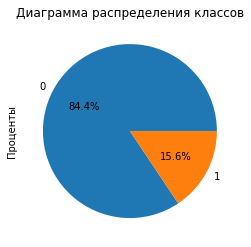

In [7]:
contract.EndDate.map(lambda x: 0 if x == "No" else 1).value_counts().plot(kind = 'pie', autopct = '%1.1f%%',
                                                                        ylabel = 'Проценты',
                                                                        title = 'Диаграмма распределения классов');

In [8]:
contract.describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7032.000000
mean,64.761692,2118.621822
std,30.090047,2112.736199
min,18.250000,19.050000
25%,35.500000,439.745000
50%,70.350000,1345.275000
75%,89.850000,3239.317500
max,118.750000,9221.380000


Просмотрим данные в таблице personal

In [9]:
personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [10]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


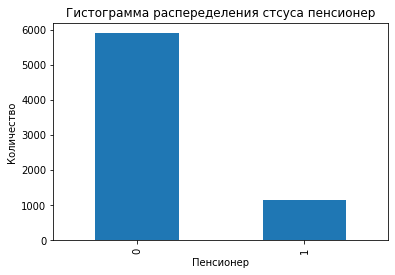

In [11]:
personal.SeniorCitizen.value_counts().plot(kind = 'bar', ylabel = 'Количество',
                                           xlabel ='Пенсионер', title = 'Гистограмма распеределения стсуса пенсионер');

Статусом пенсионера обладает около 1000 пользователей

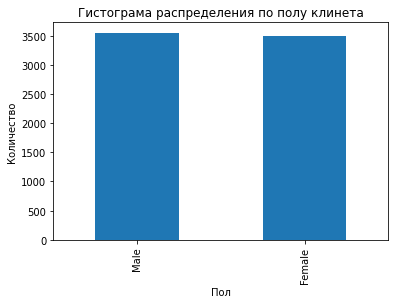

In [12]:
personal.gender.value_counts().plot(kind = 'bar', ylabel = 'Количество', xlabel = 'Пол', 
                                    title = 'Гистограма распределения по полу клинета');

Распределение пола пользователей равномерное

Просмотрим данные в таблице internet

In [13]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [14]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [15]:
internet.nunique()

customerID          5517
InternetService        2
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
dtype: int64

Признаки бинарные, имют 2 вариации значения

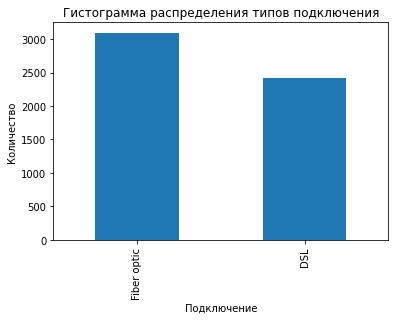

In [16]:
internet.InternetService.value_counts().plot(kind = 'bar', ylabel = 'Количество', xlabel = 'Подключение', 
                                             title = 'Гистограмма распределения типов подключения');

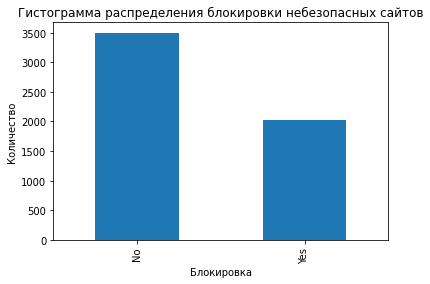

In [17]:
internet.OnlineSecurity.value_counts().plot(kind = 'bar', ylabel = 'Количество', xlabel = 'Блокировка', 
                                            title = 'Гистограмма распределения блокировки небезопасных сайтов');

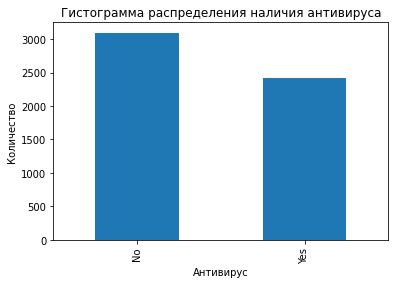

In [18]:
internet.DeviceProtection.value_counts().plot(kind = 'bar', ylabel = 'Количество', xlabel = 'Антивирус', 
                                              title = 'Гистограмма распределения наличия антивируса');

Просмотрим данные в таблице phone

In [19]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


В таюлице одна колонка с признаком, указателем на подключение телефона к нескольким линиям одновременно, многоканальность

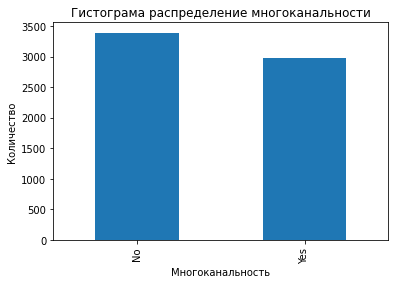

In [20]:
phone.MultipleLines.value_counts().plot(kind = 'bar', ylabel = 'Количество',
                                           xlabel = 'Многоканальность', title = 'Гистограма распределение многоканальности');

### Объединение и предобработка данных

In [21]:
RANDOM_STATE = 251223

In [22]:
data = [contract, personal, internet, phone]
for datset in data:
    display(datset.shape)
    display(datset.columns)

(7043, 8)

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

(7043, 5)

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

(5517, 8)

Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

(6361, 2)

Index(['customerID', 'MultipleLines'], dtype='object')

In [23]:
df = reduce(lambda left, right: pd.merge(left, right, on = 'customerID', how = 'left'), data)

In [24]:
df.shape

(7043, 20)

In [25]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Заменим 'No' на '2020-02-01' и приведем столбец к формату datetime

In [26]:
df['EndDate'] = df['EndDate'].replace('No', '2020-02-01')
df.EndDate = pd.to_datetime(df.EndDate)

Удалим пользователей без информции по столцу TotalCharges

In [27]:
df.drop((df.TotalCharges[df.TotalCharges.isna() == True]).index, inplace = True)
df = df.reset_index(drop = True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7032 non-null   object        
 9   SeniorCitizen     7032 non-null   int64         
 10  Partner           7032 non-null   object        
 11  Dependents        7032 non-null   object        
 12  InternetService   5512 non-null   object        
 13  OnlineSecurity    5512 non-null   object        
 14  OnlineBackup      5512 n

In [29]:
df.MonthlyCharges.isna().sum()

0

In [30]:
df_train, df_test = train_test_split(df, test_size = 0.25, random_state = RANDOM_STATE)

In [31]:
df_train.shape

(5274, 20)

In [32]:
df_test.shape

(1758, 20)

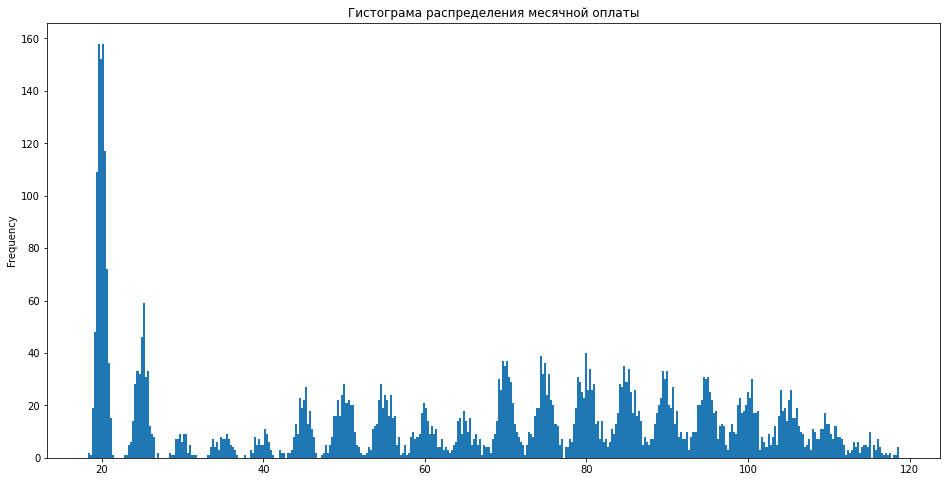

In [33]:
df_train.MonthlyCharges.plot(kind = 'hist',bins = 400, figsize = (16, 8), title = 'Гистограма распределения месячной оплаты');

Вбросы отсутсвуют

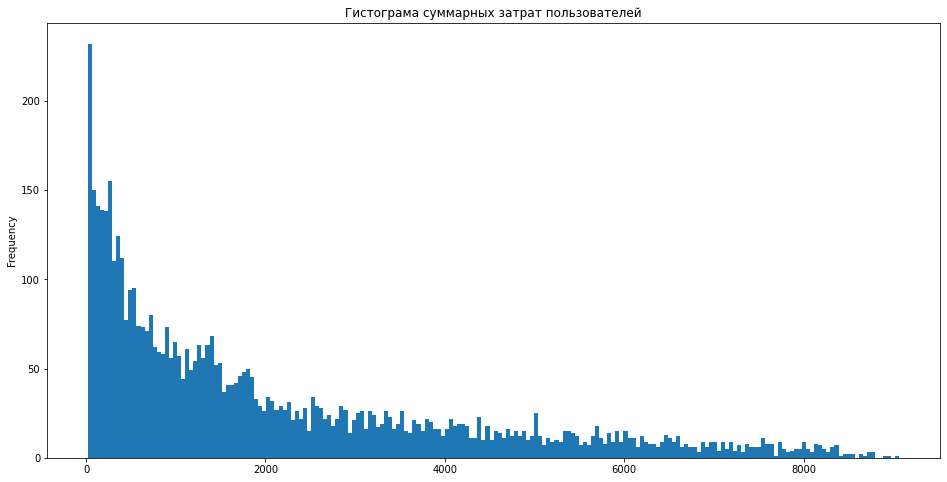

In [34]:
df_train.TotalCharges.plot(kind = 'hist',bins = 200, figsize = (16, 8), title = 'Гистограма суммарных затрат пользователей');

Вбросов нет, можно приступать к шагу кодирования признаков.

In [35]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5274 entries, 1255 to 2375
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        5274 non-null   object        
 1   BeginDate         5274 non-null   datetime64[ns]
 2   EndDate           5274 non-null   datetime64[ns]
 3   Type              5274 non-null   object        
 4   PaperlessBilling  5274 non-null   object        
 5   PaymentMethod     5274 non-null   object        
 6   MonthlyCharges    5274 non-null   float64       
 7   TotalCharges      5274 non-null   float64       
 8   gender            5274 non-null   object        
 9   SeniorCitizen     5274 non-null   int64         
 10  Partner           5274 non-null   object        
 11  Dependents        5274 non-null   object        
 12  InternetService   4127 non-null   object        
 13  OnlineSecurity    4127 non-null   object        
 14  OnlineBackup      412

Убедимся в отсутсвии 0 значений в TotalCharges

In [36]:
df_train.TotalCharges.isna().sum()

0

Делаем копию для кодирования признаков

In [37]:
df_train_col_ts = df_train.copy()
df_train_col_ts.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
1255,4187-CINZD,2016-02-01,2019-04-01,One year,No,Credit card (automatic),95.25,3691.89,Female,1,No,No,Fiber optic,No,Yes,No,No,Yes,Yes,No
456,5149-CUZUJ,2017-10-01,2020-02-01,One year,No,Bank transfer (automatic),92.90,2601.20,Male,0,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,No,No
2136,6648-INWPS,2018-10-01,2020-02-01,Month-to-month,No,Electronic check,20.15,338.52,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5635,9444-JTXHZ,2019-09-01,2020-02-01,Month-to-month,No,Electronic check,76.20,419.10,Male,0,Yes,No,Fiber optic,No,No,Yes,No,No,No,No
1867,9938-PRCVK,2016-09-01,2020-02-01,Two year,No,Bank transfer (automatic),19.70,807.70,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


In [39]:
df_train_col_ts = pd.get_dummies(df_train_col_ts, columns=['Type', 'PaperlessBilling', 
                                                        'gender', 'Partner', 
                                                       'Dependents',
                                                       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                                                      'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'])

In [40]:
df_train_col_ts.head()

,customerID,BeginDate,EndDate,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,InternetService,Type_Month-to-month,Type_One year,...,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,MultipleLines_No,MultipleLines_Yes
1255,4187-CINZD,2016-02-01,2019-04-01,Credit card (automatic),95.25,3691.89,1,Fiber optic,0,1,...,1,0,1,0,0,1,0,1,1,0
456,5149-CUZUJ,2017-10-01,2020-02-01,Bank transfer (automatic),92.90,2601.20,0,Fiber optic,0,1,...,0,1,0,1,0,1,1,0,1,0
2136,6648-INWPS,2018-10-01,2020-02-01,Electronic check,20.15,338.52,0,NaN,1,0,...,0,0,0,0,0,0,0,0,1,0
5635,9444-JTXHZ,2019-09-01,2020-02-01,Electronic check,76.20,419.10,0,Fiber optic,1,0,...,0,1,1,0,1,0,1,0,1,0
1867,9938-PRCVK,2016-09-01,2020-02-01,Bank transfer (automatic),19.70,807.70,0,NaN,0,0,...,0,0,0,0,0,0,0,0,1,0


In [41]:
onehe = OneHotEncoder(drop = 'first')
onehe_col = pd.DataFrame(onehe.fit_transform(df_train_col_ts[['PaymentMethod', 'InternetService']]).toarray(), 
                        index = df_train_col_ts.index)
onehe_col.head()

,0,1,2,3,4
1255,1.0,0.0,0.0,1.0,0.0
456,0.0,0.0,0.0,1.0,0.0
2136,0.0,1.0,0.0,0.0,1.0
5635,0.0,1.0,0.0,1.0,0.0
1867,0.0,0.0,0.0,0.0,1.0


In [42]:
df_train_col_ts = df_train_col_ts.merge(pd.DataFrame(onehe_col, index = df_train_col_ts.index), how = 'inner', left_index = True, right_index = True)
df_train_col_ts.drop(['PaymentMethod', 'InternetService'], axis = 1,inplace = True)

In [43]:
df_train_col_ts.fillna(-1, inplace = True)

Создаем дополнительный признак, количество дней использования.

In [44]:
df_train_col_ts['dayuse'] = (df_train_col_ts.EndDate - df_train_col_ts.BeginDate).dt.days

In [45]:
minsc = MinMaxScaler()
minsc_col = pd.DataFrame(minsc.fit_transform(df_train_col_ts[['MonthlyCharges', 'TotalCharges', 'dayuse']]), 
    columns = ['MonthlyCharges', 'TotalCharges', 'dayuse'], index = df_train_col_ts.index)
minsc_col.head(3)

,MonthlyCharges,TotalCharges,dayuse
1255,0.766169,0.405866,0.492335
456,0.742786,0.285338,0.360053
2136,0.018905,0.035298,0.200175


In [46]:
df_train_col_ts.drop(['MonthlyCharges', 'TotalCharges', 'dayuse'], axis=1,inplace=True)

In [47]:
df_train_col_ts = df_train_col_ts.merge(pd.DataFrame(minsc_col, index = df_train_col_ts.index), how = 'inner',
                         left_index = True, right_index = True)

In [48]:
datedef = '2020-02-01'
df_train_col_ts['target'] = (df_train_col_ts.EndDate == datedef).astype(int)
df_train_col_ts.head()

,customerID,BeginDate,EndDate,SeniorCitizen,Type_Month-to-month,Type_One year,Type_Two year,PaperlessBilling_No,PaperlessBilling_Yes,gender_Female,...,MultipleLines_Yes,0,1,2,3,4,MonthlyCharges,TotalCharges,dayuse,target
1255,4187-CINZD,2016-02-01,2019-04-01,1,0,1,0,1,0,1,...,0,1.0,0.0,0.0,1.0,0.0,0.766169,0.405866,0.492335,0
456,5149-CUZUJ,2017-10-01,2020-02-01,0,0,1,0,1,0,0,...,0,0.0,0.0,0.0,1.0,0.0,0.742786,0.285338,0.360053,1
2136,6648-INWPS,2018-10-01,2020-02-01,0,1,0,0,1,0,0,...,0,0.0,1.0,0.0,0.0,1.0,0.018905,0.035298,0.200175,1
5635,9444-JTXHZ,2019-09-01,2020-02-01,0,1,0,0,1,0,0,...,0,0.0,1.0,0.0,1.0,0.0,0.576617,0.044203,0.053438,1
1867,9938-PRCVK,2016-09-01,2020-02-01,0,0,0,1,1,0,1,...,0,0.0,0.0,0.0,0.0,1.0,0.014428,0.087145,0.533071,1


Удаляем ненужные столбцы

In [49]:
df_train_col_ts.drop(['customerID','BeginDate','EndDate'], axis=1, inplace=True)
df_train_col_ts.head()

,SeniorCitizen,Type_Month-to-month,Type_One year,Type_Two year,PaperlessBilling_No,PaperlessBilling_Yes,gender_Female,gender_Male,Partner_No,Partner_Yes,...,MultipleLines_Yes,0,1,2,3,4,MonthlyCharges,TotalCharges,dayuse,target
1255,1,0,1,0,1,0,1,0,1,0,...,0,1.0,0.0,0.0,1.0,0.0,0.766169,0.405866,0.492335,0
456,0,0,1,0,1,0,0,1,0,1,...,0,0.0,0.0,0.0,1.0,0.0,0.742786,0.285338,0.360053,1
2136,0,1,0,0,1,0,0,1,0,1,...,0,0.0,1.0,0.0,0.0,1.0,0.018905,0.035298,0.200175,1
5635,0,1,0,0,1,0,0,1,0,1,...,0,0.0,1.0,0.0,1.0,0.0,0.576617,0.044203,0.053438,1
1867,0,0,0,1,1,0,1,0,0,1,...,0,0.0,0.0,0.0,0.0,1.0,0.014428,0.087145,0.533071,1


Выделяем таргет и фичи

In [50]:
X_train = df_train_col_ts.drop('target', axis = 1)
y_train = df_train_col_ts['target']

In [51]:
X_train.shape, y_train.shape

((5274, 34), (5274,))

#### Мультиколлениарность

In [52]:
col = df_train_col_ts.phik_matrix(interval_cols=df_train_col_ts)
display(col)

,SeniorCitizen,Type_Month-to-month,Type_One year,Type_Two year,PaperlessBilling_No,PaperlessBilling_Yes,gender_Female,gender_Male,Partner_No,Partner_Yes,...,MultipleLines_Yes,0,1,2,3,4,MonthlyCharges,TotalCharges,dayuse,target
SeniorCitizen,1.000000,0.214175,0.069675,0.180417,0.247164,0.247164,0.000000,0.000000,0.000000,0.000000,...,0.221375,0.041044,0.270634,0.239917,0.393743,0.288681,0.310987,0.137815,0.023876,0.087748
Type_Month-to-month,0.214175,1.000000,0.782011,0.827912,0.265732,0.265732,0.000000,0.000000,0.429906,0.429906,...,0.131926,0.305500,0.486887,0.000000,0.375168,0.342749,0.420187,0.539417,0.761361,0.243710
Type_One year,0.069675,0.782011,1.000000,0.434354,0.070263,0.070263,0.006248,0.006248,0.131333,0.131333,...,0.000000,0.102212,0.174636,0.000000,0.134184,0.069166,0.165555,0.238768,0.371631,0.112265
Type_Two year,0.180417,0.827912,0.434354,1.000000,0.240840,0.240840,0.000000,0.000000,0.381011,0.381011,...,0.172573,0.258833,0.411670,0.000000,0.312921,0.332174,0.402744,0.478148,0.713643,0.176043
PaperlessBilling_No,0.247164,0.265732,0.070263,0.240840,1.000000,1.000000,0.000000,0.000000,0.023203,0.023203,...,0.228007,0.000000,0.321213,0.314739,0.486695,0.496276,0.475415,0.211536,0.000000,0.065993
PaperlessBilling_Yes,0.247164,0.265732,0.070263,0.240840,1.000000,1.000000,0.000000,0.000000,0.023203,0.023203,...,0.228007,0.000000,0.321213,0.314739,0.486695,0.496276,0.475415,0.211536,0.000000,0.065993
gender_Female,0.000000,0.000000,0.006248,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.017262,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
gender_Male,0.000000,0.000000,0.006248,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.017262,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Partner_No,0.000000,0.429906,0.131333,0.381011,0.023203,0.023203,0.000000,0.000000,1.000000,1.000000,...,0.211417,0.115340,0.130005,0.120060,0.000000,0.000000,0.207454,0.371015,0.436498,0.224246
Partner_Yes,0.000000,0.429906,0.131333,0.381011,0.023203,0.023203,0.000000,0.000000,1.000000,1.000000,...,0.211417,0.115340,0.130005,0.120060,0.000000,0.000000,0.207454,0.371015,0.436498,0.224246


Все коэффициенты близки к нулю, что показывает слабую линейную зависимость между фичами и таргетом

#### Баланс классов

In [53]:
imbalance_ratio = y_train.value_counts().min() / y_train.value_counts().max()
display(f"Отношение классов: {imbalance_ratio:.2f}")

'Отношение классов: 0.19'

### Обучение моделей

#### Random Forest

In [54]:
model_rf = RandomForestClassifier(random_state = RANDOM_STATE)

In [55]:
param_rf = {'n_estimators': [300, 400, 500], 'max_depth': [1, 2, 5], 
            'max_features': [2, 3, 4]}

In [56]:
grid_rf = GridSearchCV(model_rf, param_grid = param_rf, scoring = 'roc_auc', verbose = 2, cv = 3)

In [57]:
grid_rf.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ......max_depth=1, max_features=2, n_estimators=300; total time=   0.5s
[CV] END ......max_depth=1, max_features=2, n_estimators=300; total time=   0.5s
[CV] END ......max_depth=1, max_features=2, n_estimators=300; total time=   0.5s
[CV] END ......max_depth=1, max_features=2, n_estimators=400; total time=   0.6s
[CV] END ......max_depth=1, max_features=2, n_estimators=400; total time=   0.6s
[CV] END ......max_depth=1, max_features=2, n_estimators=400; total time=   0.6s
[CV] END ......max_depth=1, max_features=2, n_estimators=500; total time=   0.8s
[CV] END ......max_depth=1, max_features=2, n_estimators=500; total time=   0.8s
[CV] END ......max_depth=1, max_features=2, n_estimators=500; total time=   0.8s
[CV] END ......max_depth=1, max_features=3, n_estimators=300; total time=   0.5s
[CV] END ......max_depth=1, max_features=3, n_estimators=300; total time=   0.5s
[CV] END ......max_depth=1, max_features=3, n_es

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=251223),
             param_grid={'max_depth': [1, 2, 5], 'max_features': [2, 3, 4],
                         'n_estimators': [300, 400, 500]},
             scoring='roc_auc', verbose=2)

In [58]:
display('Параметры лучшей модели: ', grid_rf.best_params_)

'Параметры лучшей модели: '

{'max_depth': 5, 'max_features': 4, 'n_estimators': 400}

In [59]:
display('ROC_AUC = ', np.round(grid_rf.best_score_, 3))

'ROC_AUC = '

0.809

#### Константная модель

In [60]:
y_train.value_counts()

1    4435
0     839
Name: target, dtype: int64

In [61]:
pred_base = [1]*y_train.shape[0]

In [62]:
roc_auc_score(y_train, pred_base)

0.5

#### CatBoost

Для использования CatBoost лучше использовать датасет без кодирования, нужно повторить операции.

In [63]:
df_train['dayuse'] = (df_train.EndDate - df_train.BeginDate).dt.days
df_test['dayuse'] = (df_test.EndDate - df_test.BeginDate).dt.days

/tmp/ipykernel_547/2282548032.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['dayuse'] = (df_train.EndDate - df_train.BeginDate).dt.days
/tmp/ipykernel_547/2282548032.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['dayuse'] = (df_test.EndDate - df_test.BeginDate).dt.days


In [64]:
y_train_cb = (df_train.EndDate == datedef).astype(int)
y_test_cb = (df_test.EndDate == datedef).astype(int)

In [65]:
df_train.drop(['customerID','BeginDate','EndDate'], axis = 1, inplace = True)
df_test.drop(['customerID','BeginDate','EndDate'], axis = 1, inplace = True)

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [66]:
X_train_cb = df_train.copy()
X_test_cb = df_test.copy()
display(X_train_cb.head(2))
display(X_test_cb.head(2))

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,dayuse
1255,One year,No,Credit card (automatic),95.25,3691.89,Female,1,No,No,Fiber optic,No,Yes,No,No,Yes,Yes,No,1155
456,One year,No,Bank transfer (automatic),92.90,2601.20,Male,0,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,No,No,853


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,dayuse
6476,Month-to-month,Yes,Mailed check,73.55,4989.63,Male,0,Yes,No,Fiber optic,Yes,No,No,No,No,No,No,1949
826,One year,No,Electronic check,90.95,3432.45,Male,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,No,No,1127


In [67]:
X_train_cb.fillna('nan', inplace = True)
X_test_cb.fillna('nan', inplace = True)

In [68]:
display(X_train_cb.info())
display(X_test_cb.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5274 entries, 1255 to 2375
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              5274 non-null   object 
 1   PaperlessBilling  5274 non-null   object 
 2   PaymentMethod     5274 non-null   object 
 3   MonthlyCharges    5274 non-null   float64
 4   TotalCharges      5274 non-null   float64
 5   gender            5274 non-null   object 
 6   SeniorCitizen     5274 non-null   int64  
 7   Partner           5274 non-null   object 
 8   Dependents        5274 non-null   object 
 9   InternetService   5274 non-null   object 
 10  OnlineSecurity    5274 non-null   object 
 11  OnlineBackup      5274 non-null   object 
 12  DeviceProtection  5274 non-null   object 
 13  TechSupport       5274 non-null   object 
 14  StreamingTV       5274 non-null   object 
 15  StreamingMovies   5274 non-null   object 
 16  MultipleLines     5274 non-null   objec

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1758 entries, 6476 to 5042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              1758 non-null   object 
 1   PaperlessBilling  1758 non-null   object 
 2   PaymentMethod     1758 non-null   object 
 3   MonthlyCharges    1758 non-null   float64
 4   TotalCharges      1758 non-null   float64
 5   gender            1758 non-null   object 
 6   SeniorCitizen     1758 non-null   int64  
 7   Partner           1758 non-null   object 
 8   Dependents        1758 non-null   object 
 9   InternetService   1758 non-null   object 
 10  OnlineSecurity    1758 non-null   object 
 11  OnlineBackup      1758 non-null   object 
 12  DeviceProtection  1758 non-null   object 
 13  TechSupport       1758 non-null   object 
 14  StreamingTV       1758 non-null   object 
 15  StreamingMovies   1758 non-null   object 
 16  MultipleLines     1758 non-null   objec

None

In [69]:
num_col = ['MonthlyCharges', 'TotalCharges', 'dayuse']
cat_col = [column for column in list(X_train_cb.columns) if column not in num_col]

In [70]:
len(cat_col) + len(num_col) == X_train_cb.shape[1]

True

In [71]:
len(cat_col) + len(num_col) == X_test_cb.shape[1]

True

In [72]:
model = CatBoostClassifier(iterations = 2000, loss_function = 'CrossEntropy', eval_metric = 'AUC', 
                           cat_features = cat_col, random_state = RANDOM_STATE, verbose = 400)
grid = {'learning_rate': [0.01, 0.03, 0.1], 'depth': [2, 4, 6], 'l2_leaf_reg': [1, 3, 5]}
grid_search_result = model.grid_search(grid, X = X_train_cb, y = y_train_cb, cv = 3)

0:	test: 0.5657361	best: 0.5657361 (0)	total: 52.5ms	remaining: 1m 44s
400:	test: 0.8023031	best: 0.8024294 (399)	total: 1.46s	remaining: 5.8s
800:	test: 0.8088401	best: 0.8089930 (776)	total: 2.84s	remaining: 4.25s
1200:	test: 0.8155999	best: 0.8156331 (1193)	total: 4.28s	remaining: 2.85s
1600:	test: 0.8195879	best: 0.8196344 (1594)	total: 5.78s	remaining: 1.44s
1999:	test: 0.8215022	best: 0.8215022 (1999)	total: 7.31s	remaining: 0us

bestTest = 0.8215021602
bestIteration = 1999

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8215022	best: 0.8215022 (0)	total: 7.76s	remaining: 3m 21s
0:	test: 0.5657361	best: 0.5657361 (0)	total: 4.79ms	remaining: 9.57s
400:	test: 0.8155035	best: 0.8155035 (400)	total: 1.44s	remaining: 5.73s
800:	test: 0.8292124	best: 0.8293852 (796)	total: 2.9s	remaining: 4.35s
1200:	test: 0.8430110	best: 0.8430110 (1200)	total: 4.46s	remaining: 2.97s
1600:	test: 0.853047

In [73]:
display('Оптимальные параметры модели CatBoost:', grid_search_result['params'])

'Оптимальные параметры модели CatBoost:'

{'depth': 2, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [74]:
roc_auc_score(y_train_cb,model.predict_proba(X_train_cb)[:,1])

0.9670843450556508

In [75]:
print(f'ROC AUC для CatBoost: {np.mean(grid_search_result["cv_results"]["test-AUC-mean"])}')

ROC AUC для CatBoost: 0.8868265438750417


ROC AUC на CatBoost лучшая из исследованных, выберем модель CatBoost.
ROC_AUC на тренировочной получили 0.96, посчитаем метрику на тестовой выборке.

In [76]:
display(f'ROC_AUC на тестовой выборке: {roc_auc_score(y_test_cb,model.predict_proba(X_test_cb)[:,1])}')

'ROC_AUC на тестовой выборке: 0.9458377556435482'

ROC_AUC на тестовой получили 0,95 , достигли требуемого результа больше 0,85

Аccuracy на тестовой выборке

In [77]:
y_pred = model.predict(X_test_cb)
accuracy = accuracy_score(y_test_cb, y_pred)
print(f'Accuracy на тестовой выборке: {accuracy:.4f}')

Accuracy на тестовой выборке: 0.9363


Хороший результат

#### Матрица ошибок на тестовой выборке

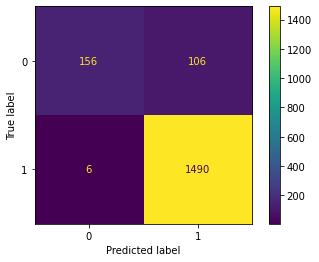

In [78]:
pred = model.predict(X_test_cb)
cm = confusion_matrix(y_test_cb, pred )
cm_display = ConfusionMatrixDisplay(cm).plot()

In [79]:
y_test_cb.value_counts()

1    1496
0     262
Name: EndDate, dtype: int64

In [80]:
262+106

368

Распределение ошибок, из 368 реально ушедших абонентов предсказано 156 верно.

#### График ROC кривой

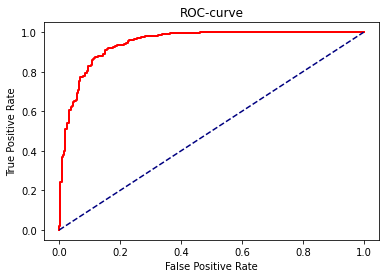

In [81]:
fpr, tpr, thresholds = roc_curve(y_test_cb, model.predict_proba(X_test_cb)[:, 1])
plt.figure()
plt.plot(fpr, tpr, color = 'red', lw = 2)
plt.plot([0, 1], [0, 1],color = 'navy', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

#### Распределение важности величин

In [82]:
pd.DataFrame(model.get_feature_importance().reshape(1,-1),
             columns = X_train_cb.columns)\
.transpose()\
.sort_values(0, ascending = False)

,0
dayuse,71.487777
TotalCharges,8.698551
Type,4.885161
MonthlyCharges,4.636783
MultipleLines,2.256914
PaymentMethod,1.895932
Partner,1.763611
OnlineBackup,0.929616
TechSupport,0.679617
DeviceProtection,0.570866


### Общий вывод и рекомедации

Список признаков участвующих в обучении:
- dayuse - получен из столбцов BeginDate и EndDate
- TotalCharges
- Type	
- MonthlyCharges	
- MultipleLines	
- PaymentMethod	
- Partner	
- OnlineBackup	
- TechSupport	
- DeviceProtection	
- StreamingMovies	
- OnlineSecurity	
- SeniorCitizen	
- Dependents	
- StreamingTV	
- PaperlessBilling	
- InternetService	
- gender	   
 
Итоговая модель:
CatBoostClassifier 

Гиперпараметры:
depth=2,
RANDOM_STATE = 251223,
l2_leaf_reg=1,
learning_rate=0.1;
ROC_AUC на тестововй выборке: 0.95
Accuracy на тестовой выборке: 0.94

На основании показателей модель может быть использована как инструкмент по указанию на клиентов, которых необходимо стимулировать подарками, не давая уйти к конкурентам.